**Modelos generativos: Autoencoder com encoder/decoder Conv2D**

In [1]:
import sys, os 
os.environ['KERAS_BACKEND'] = "tensorflow"

import keras
from keras import backend as K
#from keras import layers
from keras.layers import Input, Dense, Flatten, Conv2D, Reshape, Conv2DTranspose, Lambda
#from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.utils import to_categorical

from keras.layers import Input, Dense
from keras.utils import np_utils

from keras.callbacks import ModelCheckpoint
import sys, os 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from livelossplot import PlotLossesKeras

%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

(60000, 28, 28)


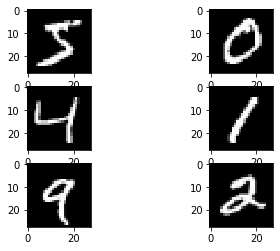

shape[0]:  60000
shape antes:  (60000, 28, 28)
shape depois:  (60000, 28, 28, 1)


In [2]:
def load_mnist_dataset(path='mnist.npz'):
    #path = get_file(path, origin='https://s3.amazonaws.com/img-datasets/mnist.npz')
    f = np.load(path)
    x_train = f['x_train']
    y_train = f['y_train']
    x_test = f['x_test']
    y_test = f['y_test']
    f.close()
    return (x_train, y_train), (x_test, y_test)


# Visualizar 6 imagens do mnist numa escala de cinzentos
def visualize_mnist(X_train):
    #(X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    plt.subplot(321)
    plt.imshow(X_train[0], cmap='gray')
    plt.subplot(322)
    plt.imshow(X_train[1], cmap='gray')
    plt.subplot(323)
    plt.imshow(X_train[2], cmap='gray')
    plt.subplot(324)
    plt.imshow(X_train[3], cmap='gray')
    plt.subplot(325)
    plt.imshow(X_train[4], cmap='gray')
    plt.subplot(326)
    plt.imshow(X_train[5], cmap='gray')
    plt.show()
    
def data_preparation_2D():
    (X_train, y_train), (X_test, y_test) = load_mnist_dataset('mnist.npz')
    print(X_train.shape)
    
    visualize_mnist(X_train)
    
    # transformar para o formato [instancias][largura][altura][pixeis]
    print("shape[0]: ",X_train.shape[0])
    print("shape antes: ",X_train.shape)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
    print("shape depois: ",X_train.shape)
    
    # normalizar os valores dos pixeis de 0-255 para 0-1
    X_train = X_train / 255
    X_test = X_test / 255
    
    # o 5 passa a ser a lista [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    #y_train = np_utils.to_categorical(y_train)
    #y_test = np_utils.to_categorical(y_test)
    
    num_classes = 10 # y_test.shape[1]
    
    return X_train, X_test, y_train, y_test, num_classes
  
    
X_train, X_test, y_train, y_test, num_classes = data_preparation_2D()

In [3]:
def create_encoder():
    input_image= Input(shape=(28, 28, 1)) #imagens do MNIST
    encoded1 = Conv2D(32, 3, padding='same', activation='relu')(input_image)
    encoded2 = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(encoded1)#com stride (2,2) vais diminuir a dimensão da imagem
    encoded3 = Conv2D(64, 3, padding='same', activation='relu')(encoded2)
    encoded4 = Conv2D(64, 3, padding='same', activation='relu')(encoded3)
    encoded5 = Flatten()(encoded4)
    encoded6 = Dense(32, activation='relu')(encoded5)
    lat_space = Dense(2)(encoded6) #o 2 refere-se à dimensão do latent space
    encoder = Model(inputs=input_image, outputs=lat_space, name='encoder')
    return encoder

def create_decoder():
    #Input for the created model are latent vectors t.
    decoder_input = Input(shape=(2,)) #o 2 refere-se à dimensão do latent space
    decoded1 = Dense(12544, activation='relu')(decoder_input) #12544 = 14*14*64
    decoded2 = Reshape((14, 14, 64))(decoded1)
    decoded3 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(decoded2)
    decoded4 = Conv2D(1, 3, padding='same', activation='sigmoid')(decoded3)
    #o output são imagens em que cada pixel tem a probabilidade de ser cor branca (sigmoid)
    decoder = Model(inputs=decoder_input, outputs=decoded4, name='decoder')
    return decoder

encoder = create_encoder()
decoder = create_decoder()
print("\n############### ENCODER #################")
encoder.summary()
print("\n############### DECODER #################")
decoder.summary()


############### ENCODER #################
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense) 

In [4]:
def create_ae():
    input_image = Input(shape=(28, 28, 1))
    lat_space = encoder(input_image)
    t_decoded = decoder(lat_space)
    ae = Model(input_image, t_decoded, name='ae')
    return ae, lat_space

ae,lat_space = create_vae()
print("\n############### AUTOENCODER #################")
ae.summary()


############### AUTOENCODER #################
Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 2)                 494178    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         56385     
Total params: 550,563
Trainable params: 550,563
Non-trainable params: 0
_________________________________________________________________


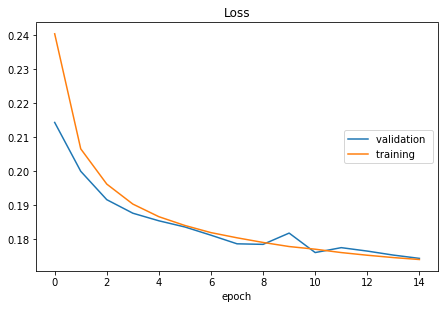

Loss
	validation       	 (min:    0.174, max:    0.214, cur:    0.174)
	training         	 (min:    0.174, max:    0.240, cur:    0.174)

Epoch 00015: loss improved from 0.17464 to 0.17407, saving model to best_weights_ae.hdf5


In [5]:
def compiletrain(ae, X_train, X_test):
    ae.compile(optimizer='rmsprop', loss='binary_crossentropy')
    checkpointer = ModelCheckpoint(filepath="best_weights_ae_mnist.hdf5", monitor = 'loss', verbose=1, save_best_only=True)
    history = ae.fit(x=X_train, y=X_train, 
                      epochs=15, 
                      shuffle=True, 
                      batch_size=128, 
                      validation_data=(X_test, X_test), 
                      verbose=1,
                      callbacks=[PlotLossesKeras(),checkpointer])
    ae.load_weights('best_weights_ae_mnist.hdf5')
    ae.save('model_ae_mnist.h5')
    return ae, history

ae = compiletrain(ae, X_train, X_test)